# Sentiment Classification of Amazon Reviews
by Michael Garaszczuk and Quy Vu Xuan

#### DESCRIPTION AND PROBLEM

It has long been demonstrated that humans are biased judges of their own behaviour, can the same be said for their ability to gauge their own reviews? Most product review processes have two elements: a discrete rating (usually out of a maximum of 5, signifying the best), along with a text field for them to voice their concerns in a personal, elaborative fashion. 

However, most ecommerce algorithms and customers look primarily at the current discrete rating. The premise of this study is that the model should be the determinant of discretizing a review score in order to provide a more accurate self-assessment. The current project compares TF-IDF and Word2Vec features as rating predictors when trained by a Logistic Regression model. A parameter grid-search was also implemented to find best combination of model and feature parameters.

To justify our choice in Logistic Regression, we briefly compared Logistic Regression with Naive Bayes using default parameters on TF-IDF features, on a 70-30 split dataset. We found that LR outperformed Naive Bayes significantly (NB ROC = 0.57), so we chose LR to investigate further.

## TABLE OF CONTENTS

#### 1. Importing the dataset
1.1 Dataset<br>
1.2 Create sample dataset
#### 2. Pipeline
2.1 Displaying data with different features
#### 3. Naive Bayes
3.1 Evaluating Naive Bayes on TF-IDF features
#### 4. Logistic Regression: TF-IDF features
4.1 Train-test 70-30 split<br>
4.2 Train-test 90-10 split<br>
4.3 Train-test 20-80 split
#### 5. Logistic Regression: word2vec features
5.1 Train-test 70-30 split<br>
5.2 Train-test 90-10 split<br>
5.3 Train-test 20-80 split
#### 6. Visualizations for best models (using 70-30 split)
6.1 Charts: LOGISTIC REGRESSION: TF-IDF<br>
6.2 Charts: LOGISTIC REGRESSION: Word2vec
#### 7. Conclusions
#### 8. Code References


## DEBUGGING

In [2]:
!rm -Rf /gpfs/global_fs01/sym_shared/YPProdSpark/user/s8bb-4c006897e4ec94-b51c55267e90/notebook/jupyter-rt/kernel-0dcdc8b1-a132-4c43-9830-27dc7b2fbcd7-20180416_160750/metastore_db

# 1. IMPORTING THE DATASET

Original training dataset consisted of 4 million written reviews and their corresponding star reviews. The dataset was simplified in that 1-2 star ratings were grouped into "bad" class (0) and 4-5 stars were "good" (1). Neutral ratings (3) were removed (by the uploadeder). The dataset is available here:

### 1.1 Dataset:

For this project, we trained the models on a subset of the full dataset; 400k samples. With equal data (400k each model), we found that TF-IDF trained model was more accurate and quicker to train.

https://www.kaggle.com/bittlingmayer/amazonreviews



In [3]:
%matplotlib inline

In [4]:
import ibmos2spark

# @hidden_cell
credentials = {
    'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
    'api_key': '8Z3xyUKlhkzRPdd27G7JrlQy7m5KXwhnL7BnVtVesl-v',
    'service_id': 'iam-ServiceId-48705193-7d1d-4f86-9ddb-85267a20a79d',
    'iam_service_endpoint': 'https://iam.ng.bluemix.net/oidc/token'}

configuration_name = 'os_6176b85e841043d4ad81ba9e7fd3ed95_configs'
cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()
# Please read the documentation of PySpark to learn more about the possibilities to load data files.
# PySpark documentation: https://spark.apache.org/docs/2.0.1/api/python/pyspark.sql.html#pyspark.sql.SparkSession
# The SparkSession object is already initialized for you.
# The following variable contains the path to your file on your IBM Cloud Object Storage.
path = cos.url('test.ft.txt.bz2', 'bigdatacoursework05dfe06df12c417eb69dd543a9eec537')
path

'cos://bigdatacoursework05dfe06df12c417eb69dd543a9eec537.os_6176b85e841043d4ad81ba9e7fd3ed95_configs/test.ft.txt.bz2'

### 1.2 Create sample dataset

In [18]:
import bz2
a = sc.textFile(path)
a = a.map(lambda x: x.lower())

# b = a.take(400000) #Here you can adjust the total data sample size (still requires train-test split) TF-IDF can handle large sizes (~200k) whereas max
                  #for Word Vector features (vectorsize=1000) is 10k before memory issues start to arise. We left it at 100 samples in case you wish to run it.
# b = sc.parallelize(b)

c = a.map(lambda x: (int(x[9])-1)) #Extract labels. Minus one because originally, the labels were given as 1 and 2. This step transforms the labels to 0 and 1.
d = a.map(lambda x: x[11:]) #Extract content
y = c.zip(d) #combine
    
ydf = y.toDF(['label','content']) #convert to dataframe
ydf = ydf.selectExpr("cast(label as int) as label", "content") 
ydf.show(10)
ydf.printSchema()

+-----+--------------------+
|label|             content|
+-----+--------------------+
|    1|great cd: my love...|
|    1|one of the best g...|
|    0|batteries died wi...|
|    1|works fine, but m...|
|    1|great for the non...|
|    0|dvd player crappe...|
|    0|incorrect disc: i...|
|    0|dvd menu select p...|
|    1|unique weird orie...|
|    0|not an "ultimate ...|
+-----+--------------------+
only showing top 10 rows

root
 |-- label: integer (nullable = true)
 |-- content: string (nullable = true)



### 1.3 Remove punctuation

In [37]:
# Remove punctuation
from pyspark.sql.functions import *
ydf = ydf.withColumn('content', regexp_replace('content', '[\)\(,./<>?\\#~\'@;;!\"£$%^&*-=+_?\"]',''))
ydf.take(2)

[Row(label=1, content='great cd my lovely pat has one of the great voices of her generation i have listened to this cd for years and i still love it when im in a good mood it makes me feel better a bad mood just evaporates like sugar in the rain this cd just oozes life vocals are jusat stuunning and lyrics just kill one of lifes hidden gems this is a desert isle cd in my book why she never made it big is just beyond me everytime i play this no matter black white young old male female everybody says one thing who was that singing '),
 Row(label=1, content='one of the best game music soundtracks  for a game i didnt really play despite the fact that i have only played a small portion of the game the music i heard plus the connection to chrono trigger which was great as well led me to purchase the soundtrack and it remains one of my favorite albums there is an incredible mix of fun epic and emotional songs those sad and beautiful tracks i especially like as theres not too many of those kin

# 2. PIPELINE

This portion is the main preprocessing pipeline. The words in the reviews are tokenized and stopwords are removed. Afterwards it is converted into TF words vector, and then into IDF. The resulting IDF vectors become the training features.

In [38]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, Word2Vec, HashingTF, IDF
from pyspark.ml import Pipeline

# Regular expression tokenizer
regexTokenizer = RegexTokenizer(inputCol="content", outputCol="review_words")
wordsDF = regexTokenizer.transform(ydf)

# Remove stop words
remover = StopWordsRemover(inputCol="review_words", outputCol="filtered")
wordsDF2 = remover.transform(wordsDF)

# Convert to TF words vector
hashingTF = HashingTF(inputCol="filtered", outputCol="TF") #, numFeatures=10000 
wordsDF3 = hashingTF.transform(wordsDF2)

for features_label in wordsDF3.select("TF", "label").take(1):
    print(features_label)

# Convert to IDF words vector
idf = IDF(inputCol="TF", outputCol="features")
idfModel = idf.fit(wordsDF3)
wordsDF4 = idfModel.transform(wordsDF3)
print('Below is the data transformed into TF-IDF features')
wordsDF4.show(5)

#Create word vectors
word2Vec = Word2Vec(minCount=5, inputCol="filtered", outputCol="features") #vectorSize=30, 

Row(TF=SparseVector(262144, {3370: 1.0, 4200: 1.0, 4869: 1.0, 18025: 1.0, 30006: 1.0, 31684: 1.0, 36200: 1.0, 43733: 1.0, 57341: 1.0, 57508: 1.0, 58938: 1.0, 61899: 1.0, 65938: 1.0, 74473: 1.0, 82378: 1.0, 90757: 1.0, 92144: 2.0, 96638: 1.0, 101402: 1.0, 107499: 1.0, 109580: 1.0, 111782: 1.0, 113432: 1.0, 115917: 1.0, 123981: 1.0, 125372: 3.0, 126907: 1.0, 137092: 1.0, 138356: 2.0, 140784: 1.0, 140833: 1.0, 151343: 1.0, 158716: 1.0, 161826: 1.0, 172517: 1.0, 186480: 1.0, 189113: 1.0, 190892: 1.0, 193254: 1.0, 201434: 1.0, 205285: 4.0, 208258: 1.0, 208616: 1.0, 223600: 1.0, 231008: 1.0, 234280: 1.0, 240272: 1.0, 245806: 1.0, 249130: 1.0, 250475: 1.0, 256816: 1.0, 257457: 1.0}), label=1)
Below is the data transformed into TF-IDF features
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             content|        review_words|            filtered|                  TF|            features|
+-----+--------------------+

### 2.1 Displaying data with different features
(Takes a while with large dataset).

In [39]:
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idfModel])
pipelineFit = pipeline.fit(ydf)
dataset = pipelineFit.transform(ydf)
print('TF-IDF feature dataset')
dataset.show(5)

pipeline2 = Pipeline(stages=[regexTokenizer, remover, word2Vec])
pipelineFit2 = pipeline2.fit(ydf)
dataset2 = pipelineFit2.transform(ydf)
print('Word Vector feature dataset')
dataset2.show(5)

TF-IDF feature dataset
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             content|        review_words|            filtered|                  TF|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|great cd my lovel...|[great, cd, my, l...|[great, cd, lovel...|(262144,[3370,420...|(262144,[3370,420...|
|    1|one of the best g...|[one, of, the, be...|[one, best, game,...|(262144,[14,1998,...|(262144,[14,1998,...|
|    0|batteries died wi...|[batteries, died,...|[batteries, died,...|(262144,[5765,636...|(262144,[5765,636...|
|    1|works fine but ma...|[works, fine, but...|[works, fine, mah...|(262144,[12888,59...|(262144,[12888,59...|
|    1|great for the non...|[great, for, the,...|[great, nonaudiop...|(262144,[9043,145...|(262144,[9043,145...|
+-----+--------------------+--------------------+--------------------+---

# 3. NAIVE BAYES

### 3.1 Evaluating NB on TF-IDF features

In [42]:
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.evaluation import BinaryClassificationEvaluator


(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 999) #TF-IDF dataset

for i in [0.5, 1.0, 1.5]:
    # create the trainer and set its parameters
    nb = NaiveBayes(smoothing=i, modelType="multinomial")
    
    # train the model
    model = nb.fit(trainingData)
    
    # predict from the test data
    prediction = model.transform(testData)
    
    # Calculate area under the ROC curve
    evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
    ROC = evaluator.evaluate(prediction)
    AUROC_score = evaluator.evaluate(prediction, {evaluator.metricName: "areaUnderROC"})
    
    # Print out results
    print("Test: Area Under ROC with smoothing parameter = {}: {}".format(i, format(AUROC_score, '.3f')))

Test: Area Under ROC with smoothing parameter = 0.5: 0.539
Test: Area Under ROC with smoothing parameter = 1.0: 0.539
Test: Area Under ROC with smoothing parameter = 1.5: 0.539


# 4. LOGISTIC REGRESSION: TF-IDF FEATURES

In [6]:
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import LogisticRegressionModel
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.tuning import TrainValidationSplit, ParamGridBuilder

import matplotlib.pyplot as plt
import numpy as np
from time import time

### 4.1 Train-test 70-30 split:

In [9]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.70, 0.3], seed = 2000)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idfModel, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 1000, 10000, 100000]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()
# Make predictions on test documents. cvModel uses the best model found (lrModel).
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|!!why pay for thi...|[0.91433887252130...|    0|       0.0|
|" great fiction n...|[0.13940101266476...|    0|       1.0|
|"a classic" as an...|[0.67034259304728...|    0|       0.0|
|"a heart made out...|[0.92761523227264...|    0|       0.0|
|"alive": go p.o.d...|[0.02137955915871...|    0|       1.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.933719898576614
Time to train in seconds:
443.01078605651855


In [29]:
#Get best RegParam and numFeatures for 70-30 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

NF = model.bestModel.stages[2].getNumFeatures()


print('Best RegParam and numFeatures values are:')
print(RP[0], NF)

Best RegParam and numFeatures values are:
0.1 10000


##### RESULTS (4.1) Best Params for 70-30 train-test split:

LR with 10000 features and 0.1 regparam (best combo)

ROC: <br>0.9220988626134164

Time to train in seconds: <br> 532.0604159832001

### 4.2 Train-test 90-10 split

In [30]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.90, 0.1], seed = 100)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idfModel, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 1000, 10000, 100000]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()

# Make predictions on test documents. 
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|" this is not it....|[0.45611786181752...|    0|       1.0|
|"and the band pla...|[0.86433461267588...|    0|       0.0|
|"bored on thursda...|[0.70978882139664...|    0|       0.0|
|"culinary holy gr...|[0.68538238023555...|    0|       0.0|
|"flawless victory...|[0.97690176370966...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.9259325040041
Time to train in seconds:
556.6214768886566


In [ ]:
#Get best RegParam and numFeatures for 90-10 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

NF = model.bestModel.stages[2].getNumFeatures()


print('Best RegParam and numFeatures values are:')
RP[0], NF

##### RESULTS (4.2) Best Params for 90-10 train-test split:
LR with 10000 features and 0.1 regparam (best combo)


ROC: <br> 0.9259325040041

Time to train in seconds: <br> 556.6214768886566

This slight increase in accuracy was expected given a larger training size.

### 4.3 Train-test 20-80 split

In [31]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.2, 0.8], seed = 120)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idfModel, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(hashingTF.numFeatures, [100, 1000, 10000, 100000]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()


# Make predictions on test documents. 
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|!!!! do not purch...|[0.85113850176799...|    0|       0.0|
|!!!not enough to ...|[0.32239906927907...|    0|       1.0|
|!!!please note!!!...|[0.68707524603882...|    0|       0.0|
|" smile"............|[0.82254399998427...|    0|       0.0|
|" this is not it....|[0.59721921112047...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.9023694376121802
Time to train in seconds:
477.7003083229065


In [32]:
#Get best RegParam and numFeatures for 20-80 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

NF = model.bestModel.stages[2].getNumFeatures()


print('Best RegParam and numFeatures values are:')
RP[0], NF

Best RegParam and numFeatures values are:


(0.1, 10000)

##### RESULTS (4.3) Best Params for 20-80 train-test split:
LR with 10000 features and 0.1 regparam (best combo)


ROC: <br> 0.9023694376121802

Time to train in seconds: <br> 477.7003083229065


Decrease in ROC (as well as training time) also unsurprising.

# 5. LOGISTIC REGRESSION: WORD2VEC FEATURES

Here we examine LR's performance using Word2vec features.

In [ ]:
from pyspark.ml.feature import Word2VecModel

### 5.1 Train-test 70-30 split:

In [6]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.7, 0.3], seed = 695)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, word2Vec, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(word2Vec.vectorSize, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()
# Make predictions on test documents. 
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|""" solution for ...|[0.96555591545282...|    0|       0.0|
|"be afraid, be ve...|[0.81301753159905...|    0|       0.0|
|"bored on thursda...|[0.47824064990582...|    0|       1.0|
|"case closed"!?!?...|[0.76371035582002...|    0|       0.0|
|"clay" does not h...|[0.60353443394332...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.8892915180629861
Time to train in seconds:
1440.287698507309


In [7]:
#Get best RegParam and vector size for 70-30 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

VS = [x._java_obj.getVectorSize()
for x in model.bestModel.stages if isinstance(x, Word2VecModel)]

print('Best RegParam and vector size values are:')
RP, VS

Best RegParam and vector size values are:


([0.001], [30])

##### RESULTS (5.1) Best Params for 70-30 train-test split:
LR with word2vec vector size 30 and 0.001 regparam (best combo)

ROC: <br> 0.8892915180629861

Time to train in seconds: <br> 1440.287698507309

### 5.2 Train-test 90-10 split:

In [7]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.7, 0.3], seed = 695)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, word2Vec, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(word2Vec.vectorSize, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()
# Make predictions on test documents. 
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|!: this doll is v...|[0.98649896395114...|    0|       0.0|
|"4" for content, ...|[0.95936461549405...|    0|       0.0|
|"alex is fun, the...|[0.28973871133474...|    0|       1.0|
|"america" is one ...|[0.77074468074995...|    0|       0.0|
|"american" lawn m...|[0.83103914135234...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.8837599164967989
Time to train in seconds:
1835.438845872879


In [8]:
#Get best RegParam and vector size for 20-80 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

VS = [x._java_obj.getVectorSize()
for x in model.bestModel.stages if isinstance(x, Word2VecModel)]

print('Best RegParam and vector size values are:')
RP, VS

Best RegParam and vector size values are:


([0.001], [30])

##### RESULTS (5.2) Best Params for 90-10 train-test split:
LR with word2vec vector size X and X regparam (best combo)

ROC: <br> 0.8837599164967989

Time to train in seconds: <br>
1835.438845872879

### 5.3 Train-test 20-80 split:

In [8]:
# Train-Test split) 
(train_set, test_set) = ydf.randomSplit([0.2, 0.8], seed = 695)

# Pick best ML model.
lr = LogisticRegression(maxIter=10, family ='binomial')

#declare our pipeline.
pipeline = Pipeline(stages=[regexTokenizer, remover, word2Vec, lr])

#Create our grid for grid search of best params.
paramGrid = ParamGridBuilder() \
    .addGrid(word2Vec.vectorSize, [10, 20, 30]) \
    .addGrid(lr.regParam, [0.1, 0.01, 0.001]) \
    .build()

tvs = TrainValidationSplit(estimator=pipeline,
                           estimatorParamMaps=paramGrid,
                           evaluator=BinaryClassificationEvaluator(),
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Train and choose the best set of parameters.
startTime = time()
model = tvs.fit(train_set)
endTime = time()
# Make predictions on test documents. 
prediction = model.transform(test_set)
selected = prediction.select("content", "probability", "label", "prediction").show(5)
#for row in selected:
#    print(row)

# Evaluate result with ROC
evaluator = BinaryClassificationEvaluator(labelCol="label", metricName="areaUnderROC")
ROC = evaluator.evaluate(prediction)
print('ROC:')
print(ROC)
totalTime = endTime - startTime 
print('Time to train in seconds:')
print(totalTime)

+--------------------+--------------------+-----+----------+
|             content|         probability|label|prediction|
+--------------------+--------------------+-----+----------+
|!!!! do not purch...|[0.85830014341935...|    0|       0.0|
|!!!not enough to ...|[0.20458024990134...|    0|       1.0|
|!!!please note!!!...|[0.81351864377722...|    0|       0.0|
|" great fiction n...|[0.28642571312206...|    0|       1.0|
|" smile"............|[0.75054734376017...|    0|       0.0|
+--------------------+--------------------+-----+----------+
only showing top 5 rows

ROC:
0.8722342208478728
Time to train in seconds:
774.2305555343628


In [9]:
#Get best RegParam and vector size for 20-80 train-test split
RP = [x._java_obj.getRegParam() 
for x in model.bestModel.stages if isinstance(x, LogisticRegressionModel)]

VS = [x._java_obj.getVectorSize()
for x in model.bestModel.stages if isinstance(x, Word2VecModel)]

print('Best RegParam and vector size values are:')
RP, VS

Best RegParam and vector size values are:


([0.01], [30])

##### RESULTS (5.3) Best Params for 20-80 train-test split:
LR with word2vec vector size 30 and 0.01 regparam (best combo)

ROC: <br> 0.8722342208478728

Time to train in seconds: <br>
774.2305555343628

# 6. VISUALIZATIONS FOR BEST MODELS (70-30 SPLIT)

In [11]:
#Takes some time, depending on the dataset size. 

hashingTF = HashingTF(inputCol="filtered", outputCol="TF", numFeatures = 10000) #MANUALLY SPECIFY BEST numFeatures
pipeline = Pipeline(stages=[regexTokenizer, remover, hashingTF, idfModel])
pipelineFit = pipeline.fit(ydf)
dataset = pipelineFit.transform(ydf)
print('TF-IDF feature dataset')
dataset.show(5)


word2Vec = Word2Vec(vectorSize=30,minCount=5, inputCol="filtered", outputCol="features") #MANUALLY SPECIFY BEST vectorSize
pipeline2 = Pipeline(stages=[regexTokenizer, remover, word2Vec])
pipelineFit2 = pipeline2.fit(ydf)
dataset2 = pipelineFit2.transform(ydf)
print('Word Vector feature dataset')
dataset2.show(5)

TF-IDF feature dataset
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|label|             content|        review_words|            filtered|                  TF|            features|
+-----+--------------------+--------------------+--------------------+--------------------+--------------------+
|    1|great cd: my love...|[great, cd:, my, ...|[great, cd:, love...|(10000,[126,151,3...|(10000,[126,151,3...|
|    1|one of the best g...|[one, of, the, be...|[one, best, game,...|(10000,[312,325,6...|(10000,[312,325,6...|
|    0|batteries died wi...|[batteries, died,...|[batteries, died,...|(10000,[152,157,8...|(10000,[152,157,8...|
|    1|works fine, but m...|[works, fine,, bu...|[works, fine,, ma...|(10000,[89,185,93...|(10000,[89,185,93...|
|    1|great for the non...|[great, for, the,...|[great, non-audio...|(10000,[157,172,5...|(10000,[157,172,5...|
+-----+--------------------+--------------------+--------------------+---

### 6.1 CHARTS: LOGISTIC REGRESSION: TF-IDF

In [12]:
(trainingData, testData) = dataset.randomSplit([0.7, 0.3], seed = 999)

In [13]:
lr = LogisticRegression(maxIter=10, regParam=0.1, family = "binomial") #Specify best regParam

# Train model with Training Data
lrModel = lr.fit(trainingData)

trainingSummary = lrModel.summary
predictions = lrModel.transform(testData)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

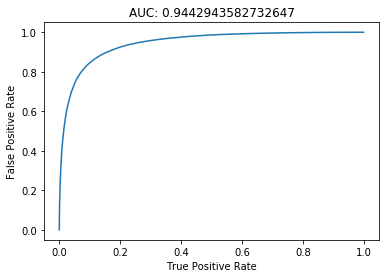

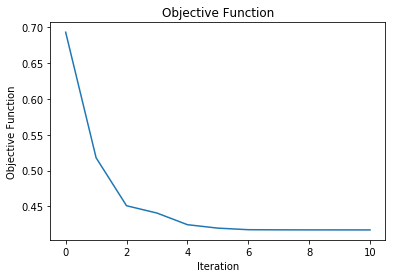

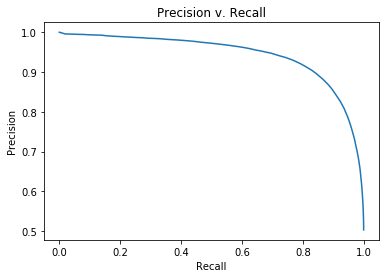

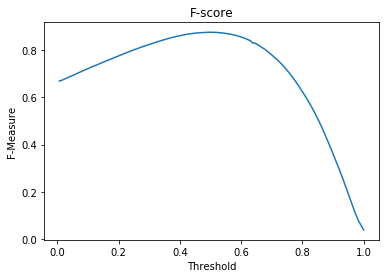

In [15]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('AUC: ' + str(trainingSummary.areaUnderROC))
plt.show()

objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.title('Objective Function')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision v. Recall')
plt.show()

f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.title('F-score')
plt.show()

### 6.2 CHARTS: LOGISTIC REGRESSION: WORD2VEC

In [16]:
(trainingData2, testData2) = dataset2.randomSplit([0.7, 0.3], seed = 888)

In [18]:
lr = LogisticRegression(maxIter=10, regParam=0.001, family = "binomial")  #Specify best regParam

# Train model with Training Data
lrModel = lr.fit(trainingData2)

trainingSummary = lrModel.summary
predictions = lrModel.transform(testData2)
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")

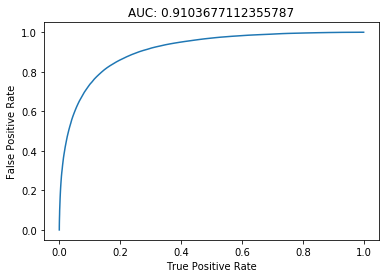

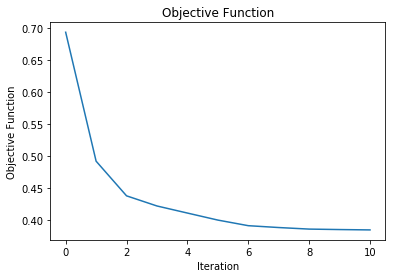

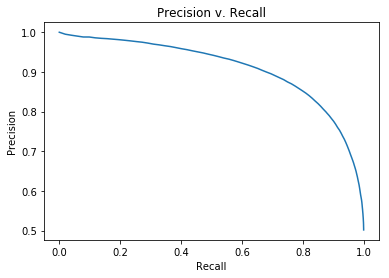

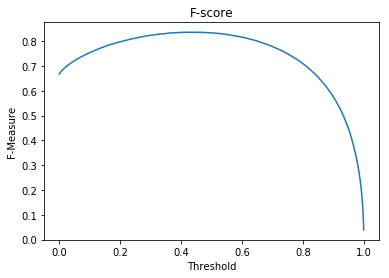

In [21]:
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('AUC: ' + str(trainingSummary.areaUnderROC))
plt.show()

objectiveHistory = trainingSummary.objectiveHistory
plt.plot(objectiveHistory)
plt.ylabel('Objective Function')
plt.xlabel('Iteration')
plt.title('Objective Function')
plt.show()

pr = trainingSummary.pr.toPandas()
plt.plot(pr['recall'],pr['precision'])
plt.ylabel('Precision')
plt.xlabel('Recall')
plt.title('Precision v. Recall')
plt.show()

f = trainingSummary.fMeasureByThreshold.toPandas()
plt.plot(f['threshold'],f['F-Measure'])
plt.ylabel('F-Measure')
plt.xlabel('Threshold')
plt.title('F-score')
plt.show()

# 7. CONCLUSIONS

TF-IDF features were more accurate predictors of reviewer’ rating than Word Vectors. Moreover the time to train the LR classifier on TF-IDF features was substantially shorter than Word Vectors. TF-IDF features also took less LR iterations to minimize loss.<br>

On average, it took approximately 3 times as long to train Word2vec features than TF-IDF. Furthermore, these features quickly became computationally overwhelming as large vector sizes would result in out-of-memory and time-out errors. Originally, the vector sizes in word2vec features to be compared were 100, 1000 and 10000, similar to the number of features in TF-IDF. This vector size then added an additional constraint onto the data size, where the largest dataset that could be trained before causing a memory error was 10,000 samples. The resulting ROC was approximately 0.77 in these instances. <br>

However, it appears the word2vec has the advantage in that it can do more with less. Whereas a low number (100) of TF-IDF features led to mediocre performance (ROC = 0.69-0.75),  Word2vec yielded an ROC of  0.89 with a vector size of 30, whereas the best TF-IDF trained model utilized 10000.